In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from nn import *

Read in the Data

In [2]:
pos=read_text_file("data/rap1-lieb-positives.txt")
neg=read_fasta_file("data/yeast-upstream-1k-negative.fa")
print(len(pos),len(pos[0]))
print(len(neg),len(neg[0]))

137 17
3163 1000


For balancing my dataset I wanted to upsample my postives (sample with replacment) as the postive sites are likley to be found mulitple times throughout the genome.There was also a much larger set that is negative. In order to have the same size inputs and to balance the training data, I randomly sampled both an even number of times based on the input size I gave. For the negative training set I also randomly selected 17 base pair chunks in order to match input size.

In [3]:
sample_data,sample_labels=sample_seqs(pos+neg, labels=([1]*len(pos))+([0]*len(neg)), total_samples=5000)
print(len(sample_data),len(sample_labels))
print(sample_data[0:5],sample_labels[0:5])

5000 5000
['TCACCCGTACATCCACG', 'TTTATGAACAAATTGCT', 'AGCTTCCATTAGATCGG', 'AGATCCGTACATCTTAG', 'TAACCCATACACCTCAT'] [1, 0, 0, 1, 1]


Next I want to one hot encode the sequences 

In [4]:
sample_encoded=one_hot_encode_seqs(sample_data)
np.array(sample_encoded[0:5])

array([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

Now I split the data into train and valildaiton 

In [5]:
# Split off Final test set
X_train, X_test, y_train, y_test = train_test_split(np.array(sample_encoded), np.array(sample_labels), test_size=0.2, random_state=123)

# Split intial train into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)  
X_val

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

Set up model and fit

In [6]:
def test_model(model):
    per_epoch_loss_train,per_epoch_loss_val=model.fit(X_train,y_train,X_val,y_val)
    epochs = range(1, len(per_epoch_loss_train) + 1)
    # Step 1: Predict Reconstruction
    reconstructed_output = model.predict(X_val)

    lf=model._loss_func_dict[model._loss_func]
    # Step 2: Calculate Error
    reconstruction_error = lf(y_val,reconstructed_output)

    # Step 3: Print or Use the Average Error
    print("Average Reconstruction Error:", reconstruction_error)
    plt.plot(epochs, per_epoch_loss_train, 'b', label='Training loss')
    plt.plot(epochs, per_epoch_loss_val, 'r', label='Validation loss')
    plt.title('Training and Validation loss per epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Average Reconstruction Error: 0.6503979289461188


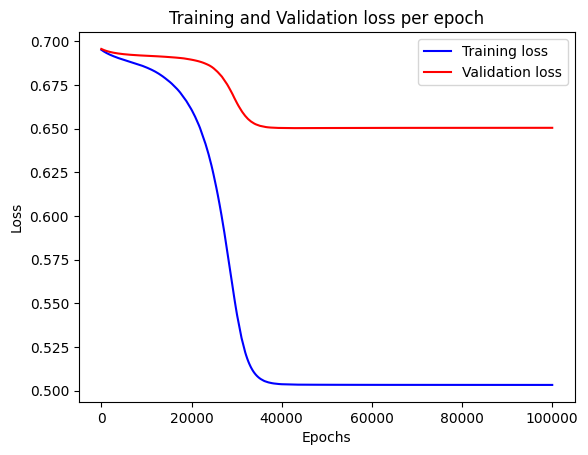

In [19]:
v1=NeuralNetwork([{'input_dim': 17*4, 'output_dim': 17, 'activation': 'relu'}, {'input_dim': 17, 'output_dim': 9, 'activation': 'relu'},{'input_dim': 9, 'output_dim': 1, 'activation': 'sigmoid'}],lr=.01,seed=17,batch_size=5,epochs=100000,loss_function="binary_cross_entropy")
test_model(v1)

Average Reconstruction Error: 0.5909515942007688


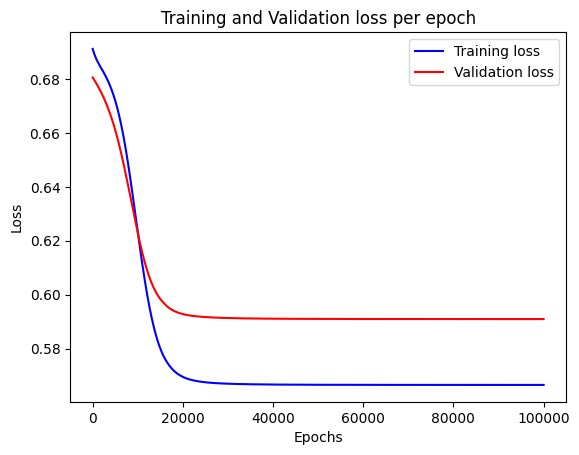

In [8]:
v2=NeuralNetwork([{'input_dim': 17*4, 'output_dim': 17, 'activation': 'relu'},{'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}],lr=.01,seed=13,batch_size=10,epochs=100000,loss_function="binary_cross_entropy")
test_model(v2)

Average Reconstruction Error: 0.5862400493537467


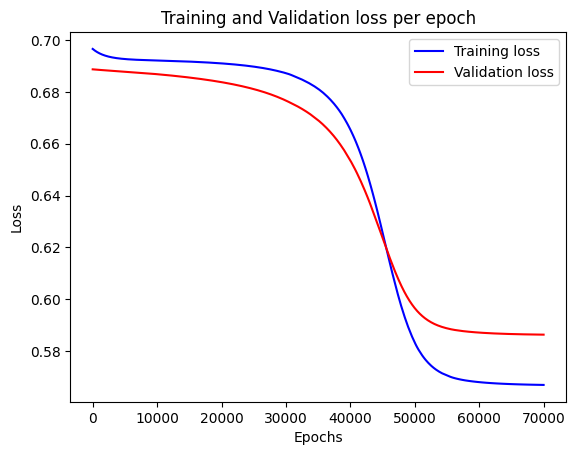

In [20]:
v3=NeuralNetwork([{'input_dim': 17*4, 'output_dim': 17*4, 'activation': 'relu'}, {'input_dim': 17*4, 'output_dim': 34, 'activation': 'relu'}, {'input_dim': 34, 'output_dim': 17, 'activation': 'relu'},{'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}],lr=.01,seed=13,batch_size=10,epochs=70000,loss_function="binary_cross_entropy")
test_model(v3)

Average Reconstruction Error: 0.1990499430383099


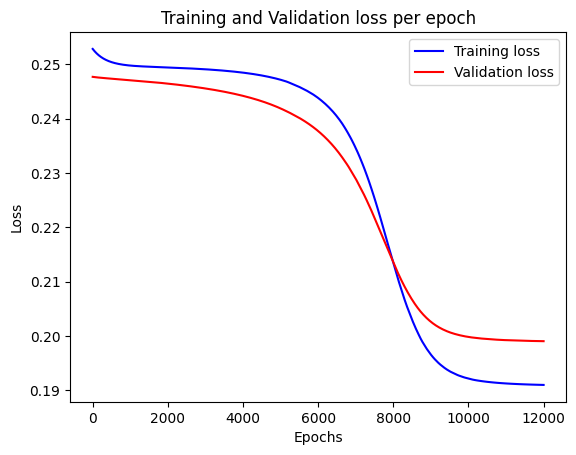

In [15]:
v4=NeuralNetwork([{'input_dim': 17*4, 'output_dim': 17*4, 'activation': 'relu'}, {'input_dim': 17*4, 'output_dim': 34, 'activation': 'relu'}, {'input_dim': 34, 'output_dim': 17, 'activation': 'relu'},{'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}],lr=1,seed=13,batch_size=10,epochs=12000,loss_function="mean_squared_error")
test_model(v4)

When Selecteding my final model I chose V3 as it had the best loss uning the binary cross entropy loss functioin. I chose binary cross because iy is designed specfically for binary calassifcation and does a good job of handeling imbalanced data (Thoough after upsampling the data is not imbalacned). It also had a smaller gap between the training and validation set suggesting that it might be more generaliable. Here I do ealry stopping in order to get the best model at ~55000 epochs where the valiadtion loss starts to plateua.


Average Reconstruction Error: 0.588676280582912


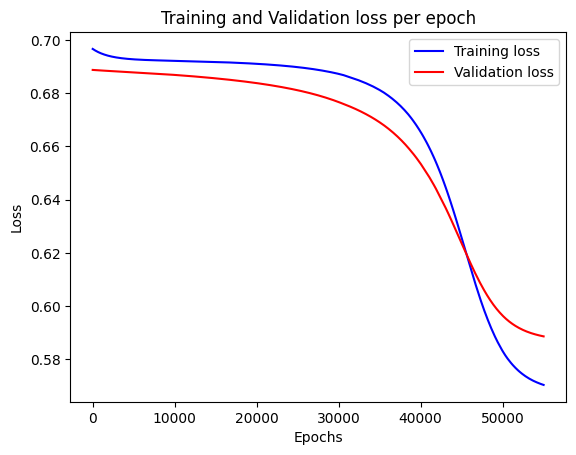

In [21]:
v3=NeuralNetwork([{'input_dim': 17*4, 'output_dim': 17*4, 'activation': 'relu'}, {'input_dim': 17*4, 'output_dim': 34, 'activation': 'relu'}, {'input_dim': 34, 'output_dim': 17, 'activation': 'relu'},{'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}],lr=.01,seed=13,batch_size=10,epochs=55000,loss_function="binary_cross_entropy")
test_model(v3)